<h1><center> HW1 - Clustering </center></h1>

<h3 style='text-align: right;'> Yuxiang (Alvin) Chen </h3>

### Executive Summary

As a Non-profit organization which focuses on promoting more accessible health care services in the US (excluding US territories), ABC is recently focusing on the health care providers which provide surgery services. This research is conducted to figure out how ABC could best group surgery health care providers based on their surgery specialty type, service place type, average charge on patients & Medicare health insurance coverage extent. This grouping is important because in the next step, ABC would like to figure out what subset of surgery healthcare providers they should focus on to promote health care accessibility through either promoting a reduction in medical charge or promoting an increase in insurance coverage.

The research team accessed the 2018 Medicare Provider Utilization and Payment Data: Physician and Other Supplier dataset from the Centers for Medicare & Medicaid Services website (cms.gov). The dataset consists of information on services and procedures provided to Medicare beneficiaries by physicians and other healthcare professionals in 2018.

The team focused on data of surgery service providers and grouped the data by each health care provider to get aggregated information related to the research goal. Exploratory data analysis is applied and K-clustering, a widely used clustering algorithm is used to figure out the appropriate grouping of health providers. The number of groups are decided based on Elbow Method, Silhouette score and business need.

The result shows that current Medicare insurance coverage fact has its merit but has improvement space. The result also gives 7 clusters of health care providers and the organization could further analyze the clusters separately to mark the priority and design customized future strategies.


### Codes & Analysis Steps

#### Prepare packages

In [1]:
# pip install packages
# !pip install pandas-profiling

In [232]:
# import packages used
import numpy as np
import pandas as pd
# from pandas_profiling import ProfileReport
import sklearn.preprocessing as preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score as silhouette_score
from sklearn.metrics import silhouette_samples as silhouette_samples
from matplotlib import pyplot as plt
import seaborn as sns
import os

#### Load in the complete raw dataset

In [22]:
#read in raw dataset
raw_data = pd.read_csv('./data/Medicare_Provider_Util_Payment_PUF_CY2018.txt', sep="\t", header=None)

E:\Programs\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,10,19,20,21,22,23,24,25) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [23]:
new_header = raw_data.iloc[0] #grab the first row for the header
raw_data = raw_data[1:] #take the data less the header row
raw_data.columns = new_header #set the header row as the df header

#### Exploratory Data Analysis on Whole Dataset

In [24]:
raw_data.columns

Index(['npi', 'nppes_provider_last_org_name', 'nppes_provider_first_name',
       'nppes_provider_mi', 'nppes_credentials', 'nppes_provider_gender',
       'nppes_entity_code', 'nppes_provider_street1', 'nppes_provider_street2',
       'nppes_provider_city', 'nppes_provider_zip', 'nppes_provider_state',
       'nppes_provider_country', 'provider_type',
       'medicare_participation_indicator', 'place_of_service', 'hcpcs_code',
       'hcpcs_description', 'hcpcs_drug_indicator', 'line_srvc_cnt',
       'bene_unique_cnt', 'bene_day_srvc_cnt', 'average_Medicare_allowed_amt',
       'average_submitted_chrg_amt', 'average_Medicare_payment_amt',
       'average_Medicare_standard_amt'],
      dtype='object', name=0)

In [25]:
raw_data_describe_df = raw_data.describe()

In [26]:
raw_data_describe_df.to_excel('raw_data_describe_df.xlsx')

In [27]:
raw_data_describe_df.loc['count',:] >= (raw_data.shape[0]*0.99)

0
npi                                  True
nppes_provider_last_org_name         True
nppes_provider_first_name           False
nppes_provider_mi                   False
nppes_credentials                   False
nppes_provider_gender               False
nppes_entity_code                    True
nppes_provider_street1               True
nppes_provider_street2              False
nppes_provider_city                  True
nppes_provider_zip                   True
nppes_provider_state                 True
nppes_provider_country               True
provider_type                        True
medicare_participation_indicator     True
place_of_service                     True
hcpcs_code                           True
hcpcs_description                    True
hcpcs_drug_indicator                 True
line_srvc_cnt                        True
bene_unique_cnt                      True
bene_day_srvc_cnt                    True
average_Medicare_allowed_amt         True
average_submitted_chrg_amt      

We read the documentation of the data, looked at how many valid entries there are in each column (refer 'raw_data_describe_df.xlsx' in Github Repo for details), and completed value count analysis on each categorical column.

We selected out columns that have at least 99% valid data entries and are useful for our research question & further analysis. We separated useful columns into four categories.

1. ID columns - this column is used to identify individual health care providers

2. Filter columns - these columns are used to exclude data rows that we do not want to include for analysis

3. Category columns - these columns are categorical features we would potentially use for grouping health care providers

4. Numeric columns - these columns are numerical features we would potentially use for grouping health care providers

These columns are presented in the code below.

In [28]:
filter_cols = ['nppes_provider_state','medicare_participation_indicator']

id_col = ['npi'] 
category_cols = ['provider_type', 'place_of_service', 'nppes_entity_code']
numeric_cols = ['line_srvc_cnt','bene_unique_cnt', 'bene_day_srvc_cnt', 
                'average_submitted_chrg_amt','average_Medicare_allowed_amt',
                'average_Medicare_payment_amt']

columns_used = id_col + filter_cols + category_cols + numeric_cols

To confirm the number of valid entries for the columns we plan to use, we look at the table below 
(The table is shown as two parts because its lenth surpasses the page width)

In [29]:
raw_data_describe_df[columns_used].iloc[:,:7]

,npi,nppes_provider_state,medicare_participation_indicator,provider_type,place_of_service,nppes_entity_code,line_srvc_cnt
count,9961866,9961865,9961865,9961865,9961865,9961865,9961865.0
unique,1061280,61,2,99,2,2,31678.0
top,1538144910,CA,Y,Diagnostic Radiology,O,I,12.0
freq,643,774584,9958654,1246653,6132242,9542267,304508.0


In [30]:
raw_data_describe_df[columns_used].iloc[:,7:]

,bene_unique_cnt,bene_day_srvc_cnt,average_submitted_chrg_amt,average_Medicare_allowed_amt,average_Medicare_payment_amt
count,9961865,9961865,9961865.0,9961865.0,9961865.00
unique,10219,13134,2037508.0,3448891.0,5886041.00
top,11,12,150.0,3.0,2.94
freq,486044,326205,97545.0,96429.0,61687.00


In [31]:
raw_data[raw_data['line_srvc_cnt'].isnull()]

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_mi,nppes_credentials,nppes_provider_gender,nppes_entity_code,nppes_provider_street1,nppes_provider_street2,nppes_provider_city,...,hcpcs_code,hcpcs_description,hcpcs_drug_indicator,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt
1,0000000001,CPT copyright 2017 American Medical Associatio...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
raw_data = raw_data[raw_data['npi'] != '0000000001']

Through the results above, we found one rolw that's not valid and besides this row, all the other rows in the raw dataset has a valid entry in the columns we used.

In [33]:
filtered_data = raw_data[columns_used]

We also want to make sure data types are corrected for any further analysis.

In [34]:
for numeric_col in numeric_cols:
    filtered_data=filtered_data.astype({numeric_col: 'float'})
for col in (id_col + category_cols + filter_cols):
    filtered_data=filtered_data.astype({col: 'string'})

We start with looking at columns that we would like to use for filtering out rows we would not want to include for further analysis.

In [35]:
filtered_data['medicare_participation_indicator'].value_counts()

Y    9958654
N       3211
Name: medicare_participation_indicator, dtype: Int64

The medicare_participation_indicator column indicate whether the provider participates in Medicare and/or accepts assignment of Medicare allowed amounts. Since insurance coverage is a one key metric we potentially would like to include and there are only 3211 rows that have the provider as not participated. We decide to exclude these 3211 rows.

In [36]:
#states to be excluded (foreign states - ZZ, unknown state - XX, US territories)
excluded_states = ['ZZ','XX','AA', 'AE', 'AP', 'AS', 'GU', 'MP', 'PR', 'VI']

In [39]:
filtered_data = filtered_data[~filtered_data['nppes_provider_state'].isin(excluded_states)]

In [44]:
1-filtered_data.shape[0]/raw_data.shape[0]

0.003314138467044092

Based on the result above, we also see that only about 0.33% of the data is on health providers which are not in US (excluding US territories). Also, Medicare is an insurance service mainly covers US health care providers. Thus ,we would like to focus our research scope on the health care providers which provide surgery treatment and operate within the US (excluding US territories).

We also would like to only use data of surgery providers based on our research interest.

In [45]:
provider_types= filtered_data['provider_type'].unique()

In [46]:
surgery_provider_types = [s for s in provider_types if "urgery" in s]

In [53]:
surgery_provider_types

['General Surgery',
 'Cardiac Surgery',
 'Orthopedic Surgery',
 'Plastic and Reconstructive Surgery',
 'Neurosurgery',
 'Thoracic Surgery',
 'Hand Surgery',
 'Vascular Surgery',
 'Oral Surgery (Dentist only)',
 'Colorectal Surgery (Proctology)',
 'Maxillofacial Surgery']

After EDA on original dataset, we filter out data for further analysis.

#### Data Filtering

In [48]:
filtered_data = filtered_data[(~filtered_data['nppes_provider_state'].isin(excluded_states)) 
         & (filtered_data['medicare_participation_indicator'] == 'Y')
        & (filtered_data['provider_type'].isin(surgery_provider_types))]

#### EDA on filtered data

After filtering the data, here are the preliminary analysis on columns we potentially would like to use for clustering (both categorical & numerical columns).

##### Catogorical columns

In [49]:
filtered_data['nppes_entity_code'].value_counts()

I    651959
Name: nppes_entity_code, dtype: Int64

We notice that 'nppes_entity_code' is all 'I' (individual) after data selection process so it will not be considered as one of the columns to use as categorical data for clustering.

In [50]:
filtered_data['place_of_service'].value_counts()

O    383963
F    267996
Name: place_of_service, dtype: Int64

'place_of_service' will be included for clustering

##### Numerical Columns

For numerical columns, we started with a correlation matrix because according to the documentation we would expect some high positive correlation among numerical columns such as 'line_srvc_cnt', 'bene_unique_cnt' and 'bene_day_srvc_cnt, because they by definition are editions on each other. Thus, we would like to confirm this hypothesis.

In [58]:
numerical_data = filtered_data[numeric_cols]

Text(78.89375000000003, 0.5, 'Numeric Culumns')

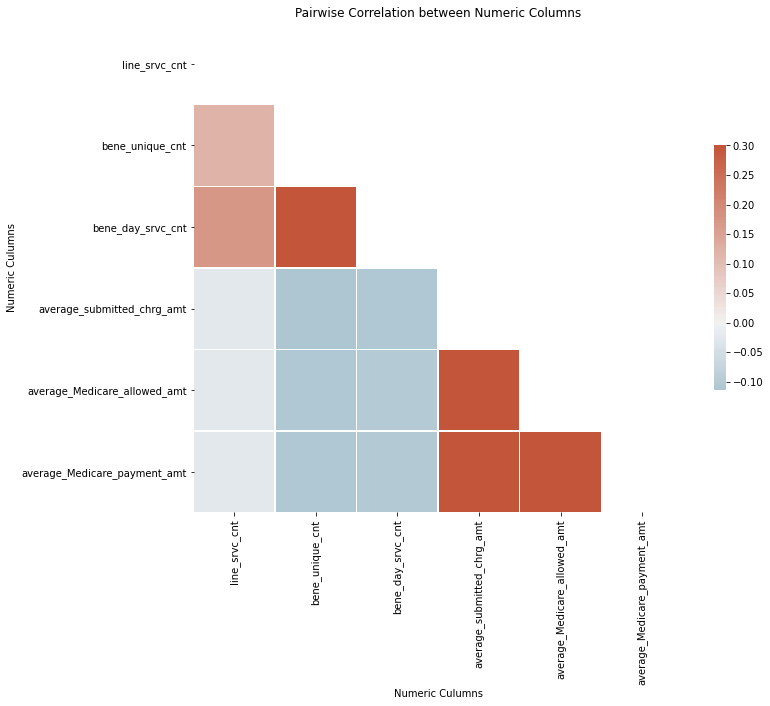

In [66]:
corr = numerical_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Pairwise Correlation between Numeric Columns')
plt.xlabel('Numeric Columns')
plt.ylabel('Numeric Columns')

From the correlation matrix, we can see that indeed, there are two groups of correlated columns. Since we would like to explore on group level instead of service level, we decide to do this analysis again after grouping.

In [52]:
filtered_data.to_csv('filtered_data.csv')

In [202]:
filtered_data.shape

(651959, 12)

In [20]:
# prof = ProfileReport(filtered_data[feature_cols])
# prof.to_file(output_file='Selected_data_EDA.html')

In [24]:
# bottom_count_provider_types = filtered_data['provider_type'].value_counts()[-15:]

#### Data Grouping

Since each row of original data is information about one hcpcs service type offered by one health care provider, to reach out goal of grouping providers instead of services, we would like to group the selected data rows by the health care providers identification column 'npi'.

We group selected rows by providers, and apply appropriate aggregaton functions to transform numerical columns crom servie level into provider level. All categorical columns that potentially will be used in clustering are originally same for rows of same provider (originally on the provider level).

In [73]:
def f(x):
    summary = {}
    summary['nppes_provider_state'] = x['nppes_provider_state'].mode().values[0]
    summary['provider_type'] = x['provider_type'].mode().values[0]
    summary['place_of_service'] = x['place_of_service'].mode().values[0]
    summary['line_srvc_cnt'] = x['line_srvc_cnt'].sum()
    summary['bene_unique_cnt'] = x['bene_unique_cnt'].sum()
    summary['bene_day_srvc_cnt'] = x['bene_day_srvc_cnt'].sum()
    summary['average_Medicare_allowed_amt'] = ((x['average_Medicare_allowed_amt'] *  x['line_srvc_cnt']).sum()) / (x['line_srvc_cnt'].sum())
    summary['average_submitted_chrg_amt'] = ((x['average_submitted_chrg_amt'] *  x['line_srvc_cnt']).sum()) / (x['line_srvc_cnt'].sum())
    summary['average_Medicare_payment_amt'] = ((x['average_Medicare_payment_amt'] *  x['line_srvc_cnt']).sum()) / (x['line_srvc_cnt'].sum())

    return pd.Series(summary, index=summary.keys())

provider_filtered_data = filtered_data.groupby('npi').apply(f)

Export grouped data for future access

In [74]:
provider_filtered_data.to_csv('provider_filtered_data.csv')

#### EDA on Grouped Data

##### Numerical Data Columns Preparation

Text(78.89375000000003, 0.5, 'Numeric Columns')

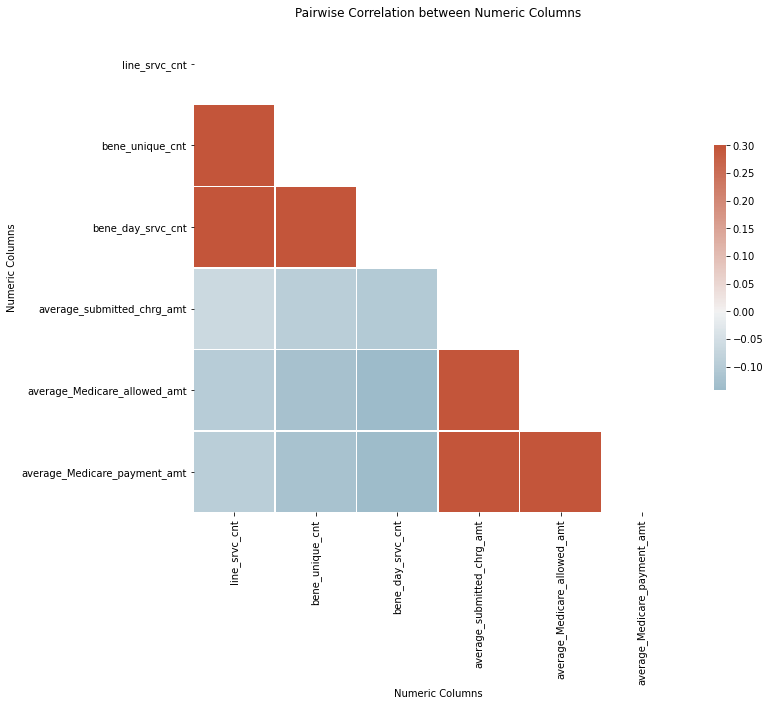

In [75]:
numerical_data_grouped = provider_filtered_data[numeric_cols]
corr = numerical_data_grouped.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Pairwise Correlation between Numeric Columns')
plt.xlabel('Numeric Columns')
plt.ylabel('Numeric Columns')

The correlation matrix shows similar result.

For the three columns related to count, since unique beneficiary number and exclusion of multiple services from one beneficiary do not add much value for our research purpose, the information from line_srv_cnt column about total service number is sufficient for our grouping, we decide to use it alone.

For the three columns related to average service payment amount, to better capture the insurance coverage information we would like to focus on, we generated two coverage percentage columns to use for clustering instead of using all 3 original columns related to average service payment amount.

In [81]:
provider_filtered_data['allowed_over_charged_pct'] = (provider_filtered_data['average_Medicare_allowed_amt']
                                                      /provider_filtered_data['average_submitted_chrg_amt'])
provider_filtered_data['paid_over_allowed_pct'] = (provider_filtered_data['average_Medicare_payment_amt'] 
                                                   / provider_filtered_data['average_Medicare_allowed_amt'])

After having all 4 numerical columns ready for clustering (2 original & 2 created ones from orignal columns), we would like to see the distribution of the numerical values.

In [82]:
def save_all_feature_hist(df,extra_notation):
    if not os.path.isdir(f'feature_distributions'):
        os.mkdir(f'feature_distributions')
    if not os.path.isdir(f'feature_distributions/{extra_notation}'):
        os.mkdir(f'feature_distributions/{extra_notation}')
    for col in df.columns:
        ax = df[col].plot.hist(bins=50).get_figure()
        plt.title(col + ' Distribution')
        plt.xlabel(col)
        ax.savefig(f'feature_distributions/{extra_notation}/{col}.png')  # saves the current figure
        plt.clf()

In [85]:
numeric_cols_used= ['line_srvc_cnt',
                  'average_submitted_chrg_amt',
                 'allowed_over_charged_pct',
                 'paid_over_allowed_pct']

The function saves the pictures and I also presented them in this document for easy access.

In [86]:
save_all_feature_hist(provider_filtered_data[numeric_cols_used],'surgery_providers_numeric_data')

<Figure size 432x288 with 0 Axes>

![title](feature_distributions/surgery_providers_numeric_data/average_submitted_chrg_amt.png)

![title](feature_distributions/surgery_providers_numeric_data/line_srvc_cnt.png)

![title](feature_distributions/surgery_providers_numeric_data/allowed_over_charged_pct.png)

![title](feature_distributions/surgery_providers_numeric_data/paid_over_allowed_pct.png)

From the 4 distribution graphs, we see that two gerneated percentage columns roughly follow normal distribution. But the 'total_line_srvc_cnt' and 'average_submitted_chrg_amt' columns both have a heavy right tail becasue of extermely large entries. Thus log transformation is applied.

Before applying log trasnformation, it's improtant to check there is no non-positive entries for these two columnes that will undergo transformaiton.

In [88]:
clustering_data_original = provider_filtered_data[['line_srvc_cnt',
                                          'average_submitted_chrg_amt',
                                         'allowed_over_charged_pct',
                                         'paid_over_allowed_pct']]

In [90]:
clustering_data_original[(clustering_data_original['line_srvc_cnt']<=0) 
                         | (clustering_data_original['average_submitted_chrg_amt']<=0)].shape

(0, 4)

The number of rows is 0 so there are no rows with either of the two columns <= 0. Log transformation can be done directly.

In [188]:
clustering_data = clustering_data_original.copy()

In [189]:
clustering_data['line_srvc_cnt'] =  np.log(clustering_data_original['line_srvc_cnt'])
clustering_data['average_submitted_chrg_amt'] =  np.log(clustering_data_original['average_submitted_chrg_amt'])

In [190]:
save_all_feature_hist(clustering_data[['line_srvc_cnt', 'average_submitted_chrg_amt']],
                      'surgery_providers_numeric_logged_data')

<Figure size 432x288 with 0 Axes>

![title](feature_distributions/surgery_providers_numeric_logged_data/average_submitted_chrg_amt.png)

![title](feature_distributions/surgery_providers_numeric_logged_data/line_srvc_cnt.png)

The two distribution graphs after log transformation show results that are much closer to normal distribution.

##### Categorical Data Columns Preparation

In [191]:
provider_filtered_data['place_of_service'].value_counts()

O    32649
F    26541
Name: place_of_service, dtype: int64

In [192]:
provider_filtered_data['provider_type'].value_counts()

Orthopedic Surgery                    20788
General Surgery                       18915
Neurosurgery                           4546
Plastic and Reconstructive Surgery     3661
Vascular Surgery                       3235
Thoracic Surgery                       2124
Hand Surgery                           1455
Colorectal Surgery (Proctology)        1450
Cardiac Surgery                        1255
Oral Surgery (Dentist only)            1094
Maxillofacial Surgery                   667
Name: provider_type, dtype: int64

Conduct One-Hot Encoding on two categorical columns used. These two columns are used because they are closely related to the health care provider's type & operation characteristic. 

State location inforamtion is not used because it is less relative to the research question because of two reasons:

1. Geological information is less relevant to the factors considered

2. We do not want to group health care providers into very large amount of groups. With the state information, both SSE & Silhouette score gives large optimal group numbers.

In [193]:
for category in ['provider_type','place_of_service']:
    clustering_data = pd.concat([clustering_data, pd.get_dummies(provider_filtered_data[category])], axis=1)

#### Data Normalization

Normalize 4 prepared numerical columns

In [194]:
final_numerical_cols = ['line_srvc_cnt',
                          'average_submitted_chrg_amt',
                         'allowed_over_charged_pct',
                         'paid_over_allowed_pct']

In [196]:
scaler = preprocessing.StandardScaler().fit(clustering_data[final_numerical_cols])
clustering_data_norm = clustering_data.copy()
clustering_data_norm[final_numerical_cols] = scaler.transform(clustering_data[final_numerical_cols])

#### Outliers Identification

In [197]:
def remove_outliers(df, norm_threshold):
    return df[(np.abs(df) < norm_threshold).all(axis=1)]
clustering_data_train = remove_outliers(clustering_data_norm, norm_threshold=3)
clustering_data_train.shape[0] / clustering_data_norm.shape[0]

0.9564453454975502

About 4.4% of data is removed as outliers.

SSE elbow method & Silhouette score are used to decide best k.

In [205]:
cancdidate_cluster_num_list = list(range(2,30))
sse = []
silh_score = []
for k in cancdidate_cluster_num_list:
    kmeas_result_model = KMeans(n_clusters = k, random_state = 10).fit(clustering_data_train)
    sse.append(kmeas_result_model.inertia_)
    silh_score.append(silhouette_score(clustering_data_train, kmeas_result_model.labels_))

Text(0, 0.5, 'SSE')

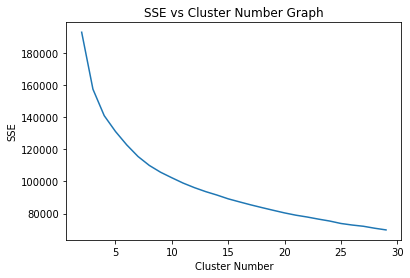

In [206]:
plt.plot(cancdidate_cluster_num_list,sse)
plt.title('SSE vs Cluster Number Graph')
plt.xlabel('Cluster Number')
plt.ylabel('SSE')

Text(0, 0.5, 'Silhouette Score')

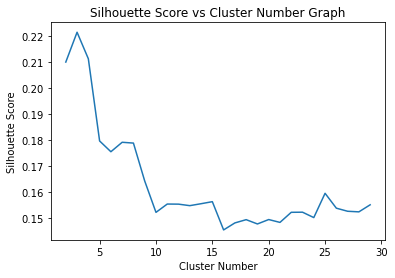

In [207]:
plt.plot(cancdidate_cluster_num_list,silh_score)
plt.title('Silhouette Score vs Cluster Number Graph')
plt.xlabel('Cluster Number')
plt.ylabel('Silhouette Score')

In [208]:
final_kmeans_model_result = KMeans(n_clusters = 7, random_state = 10).fit(clustering_data_train)

In [209]:
final_kmeans_result_summary = pd.DataFrame(final_kmeans_model_result.labels_, columns = ['Cluster'])

In [217]:
final_clustering_data_copy = clustering_data.copy()

In [220]:
final_clustering_data_copy = final_clustering_data_copy.loc[clustering_data_train.index,:]

In [222]:
final_clustering_data_copy.insert(0, "npi", final_clustering_data_copy.index)

In [223]:
final_clustering_data_copy['line_srvc_cnt'] =  np.exp(final_clustering_data_copy['line_srvc_cnt'])
final_clustering_data_copy['average_submitted_chrg_amt'] =  np.exp(final_clustering_data_copy['average_submitted_chrg_amt'])

In [224]:
final_clustering_data_copy.reset_index(drop=True, inplace=True)
final_kmeans_result_summary.reset_index(drop=True, inplace=True)

In [225]:
result_table = pd.concat([final_clustering_data_copy, final_kmeans_result_summary],axis=1)

In [226]:
result_table['Cluster'].value_counts()

6    11786
2    10494
3     9446
4     8081
0     5917
1     5521
5     5367
Name: Cluster, dtype: int64

In [227]:
cluster_means = result_table.groupby('Cluster').mean()

The final result table is presented below. It is too long to be put in one line so I separated it into two parts.

In [228]:
cluster_means.iloc[:,1:8]

,average_submitted_chrg_amt,allowed_over_charged_pct,paid_over_allowed_pct,Cardiac Surgery,Colorectal Surgery (Proctology),General Surgery,Hand Surgery
Cluster,,,,,,,
0,319.835007,0.393013,0.763547,0.015886,0.023999,0.509380,0.006591
1,206.789060,0.438343,0.692398,0.003079,0.032965,0.277124,0.025539
2,169.384817,0.378409,0.732047,0.002382,0.000858,0.018010,0.061273
3,519.892346,0.284285,0.748465,0.004340,0.043510,0.162079,0.043193
4,1461.824116,0.216913,0.768549,0.091573,0.013983,0.269397,0.003341
5,182.875768,0.634454,0.746815,0.007267,0.036147,0.419974,0.016955
6,366.279982,0.358735,0.755712,0.017478,0.031393,0.646190,0.005854


In [229]:
cluster_means.iloc[:,8:]

,Maxillofacial Surgery,Neurosurgery,Oral Surgery (Dentist only),Orthopedic Surgery,Plastic and Reconstructive Surgery,Thoracic Surgery,Vascular Surgery,F,O
Cluster,,,,,,,,,
0,0.016900,0.084671,0.026872,0.125908,0.118641,0.042251,0.028900,0.577996,0.422004
1,0.048723,0.054157,0.072270,0.282558,0.179134,0.006521,0.017932,0.138381,0.861619
2,0.000476,0.004002,0.002001,0.876787,0.010292,0.001144,0.022775,0.020678,0.979322
3,0.001694,0.046369,0.004446,0.538852,0.042981,0.011010,0.101524,0.018738,0.981262
4,0.001361,0.231407,0.005197,0.176340,0.043188,0.133523,0.030689,0.903230,0.096770
5,0.019378,0.077511,0.034097,0.210173,0.101733,0.021614,0.055152,0.386808,0.613192
6,0.000764,0.068641,0.002461,0.068726,0.026472,0.034957,0.097064,0.997709,0.002291


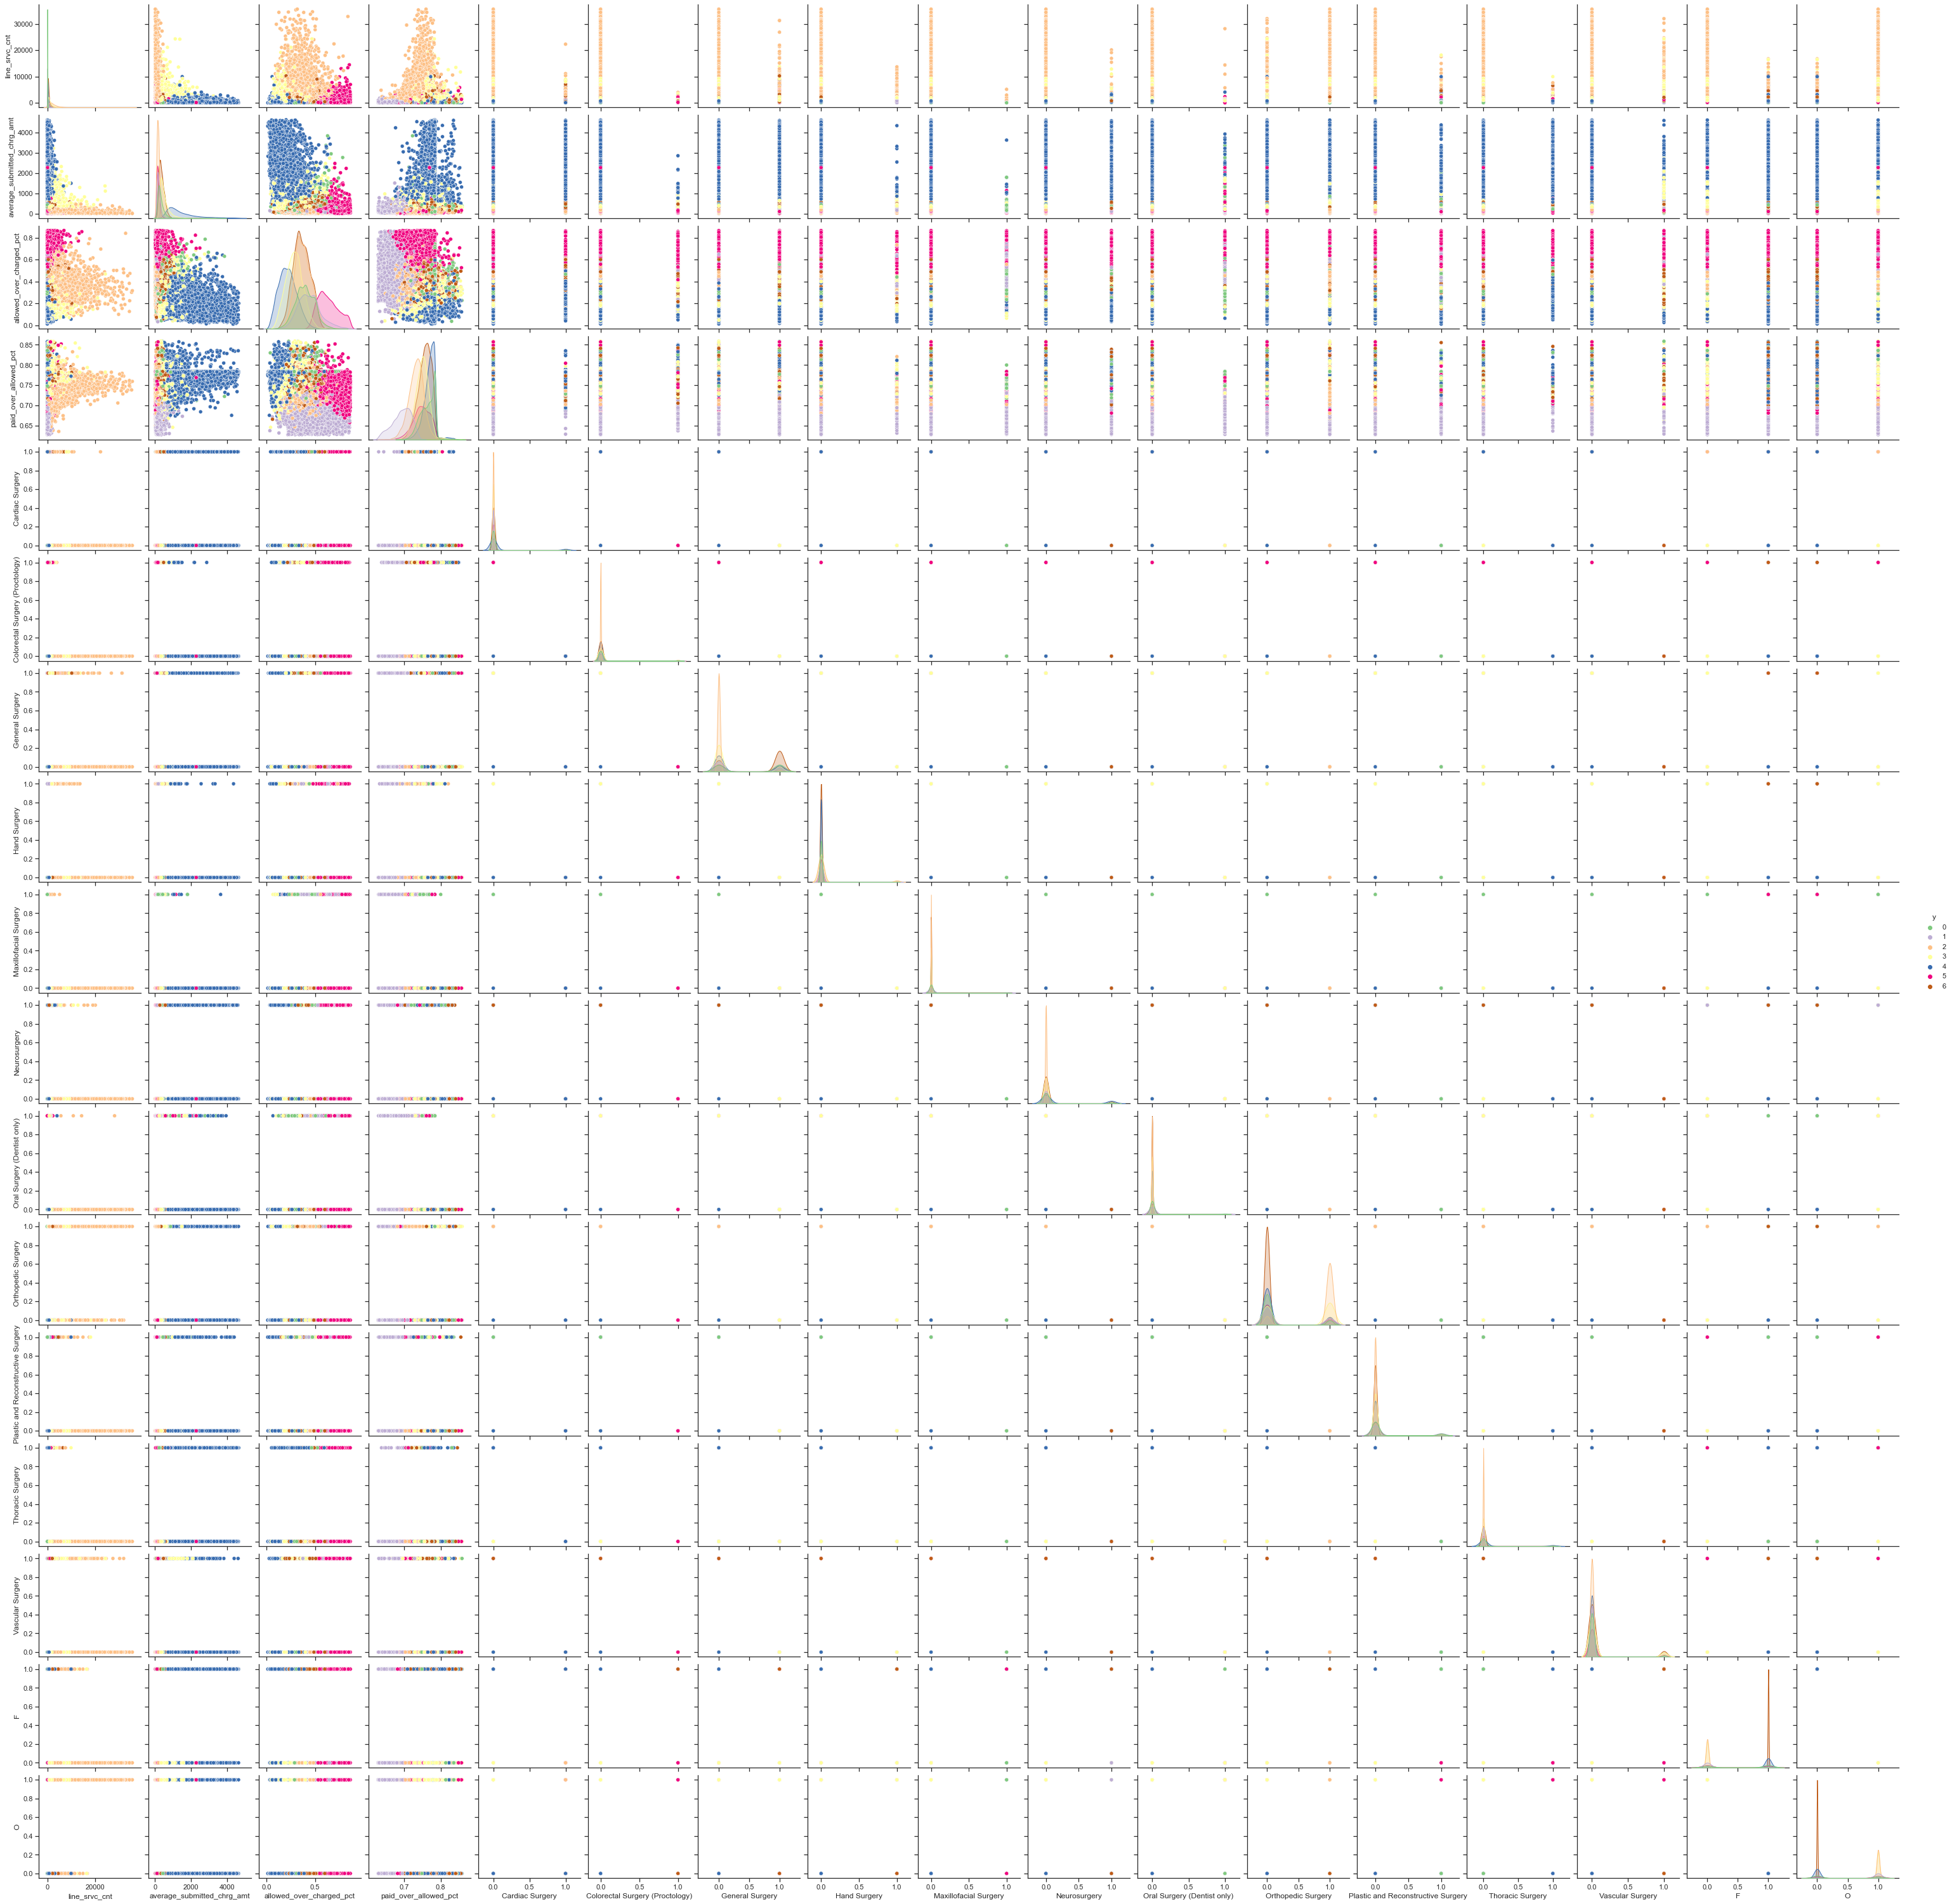

In [231]:
def plot_pairwise_scatter_plot(features, y):
    features['y'] = y
    sns_plot = sns.pairplot(features, hue="y",palette='Accent')
    return sns_plot
sns.set_theme(style="ticks")
sns_plot3 = plot_pairwise_scatter_plot(final_clustering_data_copy, final_kmeans_result_summary)
sns_plot3.savefig("sns_plot3.png")

Please look at enlargable version of this picture in github repo 'sns_plot3.png'.